## Opis projektu

Przedmiotem projektu jest ewolucja sztucznej inteligencji kierującej pojazdami w prostym środowisku 2D. Pojazdy mogą przyspieszać i zwalniać oraz skręcać w ograniczonym zakresie. Informacja, jaką dysponują przy podejmowaniu decyzji, to
* aktualna szybkość pojazdu
* długości 7 "promieni" wystrzelonych z punktu na środku frontu pojazdu i zatrzymujących się na najbliższej ścianie. Promienie skierowane są w równomiernych odstępach od 90° w lewo do 90° w prawo. 

Jakiekolwiek dotknięcie ściany przez pojazd powoduje koniec "wyścigu".

Celem jest stworzenie sztucznej inteligencji, która będzie potrafiła przejechać jak najdłuższy dystans w jak najkrótszym czasie. Do tego w miarę możliwości chcielibyśmy, żeby była w stanie przenosić umiejętności nabyte na jednym torze także na inne tory, na których nie była uczona.

## Struktura kodu

Kod jest podzielony na następujące foldery:
* `simulate` - pliki związane ze środowiskiem symulacyjnym
* `visualise` - wizualizacja ruchu pojazdów
* `ai` - kod sieci neuronowych oraz określenie problemów dla algorytmu ewolucyjnego
* `experiments` - kod źródłowy programów uruchamiających uczenie oraz wizualizację wyników

Oprócz tego ważny jest jeszcze katalog `maps`, w którym znajdują się mapy używane do uczenia i testów.

Przykładowa mapa:

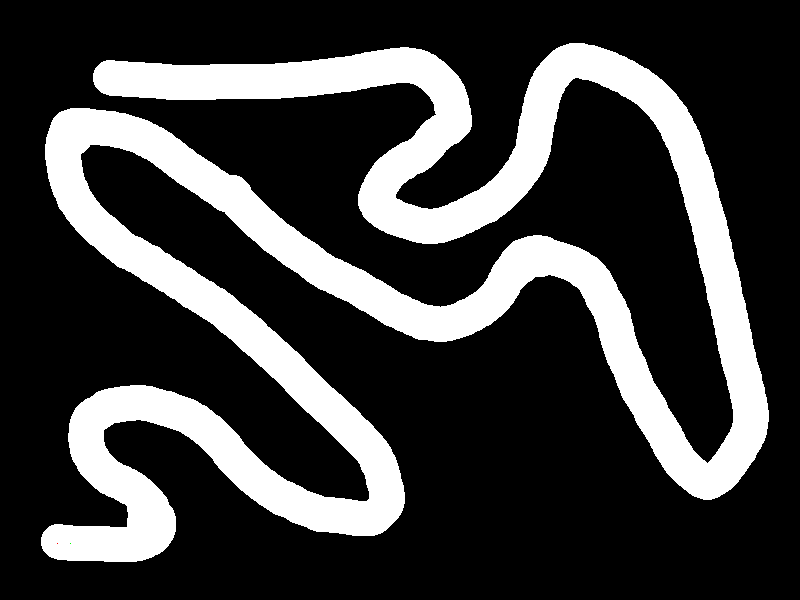

In [1]:
from IPython.display import Image
Image('maps/trasa1.png')

## Algorytm:

* Tworzona jest gęsta sieć neuronowa złożona z warstwy wejściowej, wyjściowej i 0 lub 1 wewnętrznej warstwy. Funkcja aktywacji to `tanh`
* Każdy osobnik populacji reprezentuje wagi sieci neuronowej, inicjalizowany jest losowymi wartościami z rozkładu normalnego
* Populacja ewoluuje według algorytmu NSGA-II - implementacja z biblioteki [PAGMO](https://esa.github.io/pagmo2). Kryteria optymalizacji brane pod uwagę to przejechana odległość (dokładnie, długość najkrótszej ścieżki na trasie pomiędzy punktem startowym, a końcowym) i średnia prędkość.
* Możliwa jest ewolucja przy użyciu wielu map jednocześnie - wtedy dla `k` map jest `2k` kryteriów optymalizacji

Szczegóły implementacji: wybrana wersja NSGA-II używa krzyżowania SBX (Simulated Binary Crossover) oraz mutacji wielomianowej (polynomial mutation) tak, jak w oryginalnej pracy. Algorytm został uruchomiony z parametrami:
* prawdopodobieństwo krzyżowania: $p_c = 0.95$
* parametr krzyżowania: $\eta_c = 10$
* prawdopodobieństwo mutacji: $p_m = 0.01$
* parametr mutacji: $\eta_m = 50$
* rozmiar populacji: $n = 80$
* liczba generacji: $g = 200$

## Ewolucja na pojedynczej mapie

Na początek wykonałem ewolucję na pojedynczej, niezbyt trudnej mapie. Sieć neuronowa, nawet bez ukrytej warstwy, poradziła sobie z tym problemem. Poniżej zamieszczam wykresy przedstawiające postęp uczenia.

In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [6]:
def load_logs(path):
    with open(path) as f:
        array = [[float(y) for y in x.split()] for x in f]
    return np.array(array)

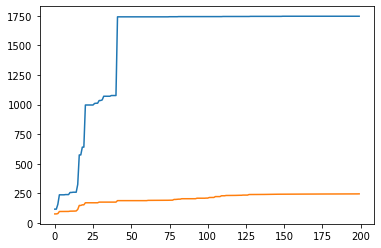

In [11]:
plt.plot(load_logs('build/logs/DNN_0207_235544'))

![Nie udało się załadować gifa](https://github.com/aprilis/racing-cars/raw/master/video1.gif)

Można też zauważyć, że nauczony w ten sposób pojazd zupełnie nie radzi sobie na innych torach

![Nie udało się załadować gifa](https://github.com/aprilis/racing-cars/raw/master/video6.gif)

W przypadku powyższej, trochę trudniejszej mapy nawet pojazdy uczone od początku na niej nie mogły sobie z nią poradzić.

![Nie udało się załadować gifa](https://github.com/aprilis/racing-cars/raw/master/video3.gif)

Rozwiązaniem okazało się być uczenie pojazdów na kilku mapach jednocześnie - znacząco poprawiało to wyniki na mapach biorących udział w uczeniu, ale też na nowych mapach. Poniżej porównanie wyników (przejechanego dystansu) ze wspólnego uczenia (niebieski kolor) i uczenia na pojedynczej mapie (pomarańczowy kolor).

maps/trasa0.png


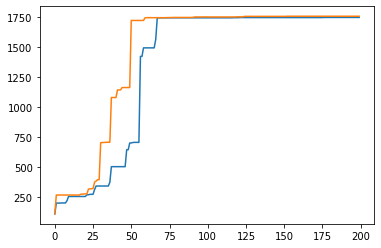

In [26]:
print('maps/trasa0.png')
plt.plot(load_logs('build/logs/DNN_20_0207_230023')[:,0])
plt.plot(load_logs('build/logs/DNN_20_0307_091817')[:,0])
plt.show()

maps/trasa1.png


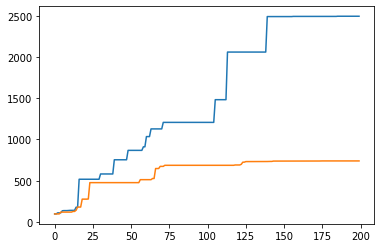

In [27]:
print('maps/trasa1.png')
plt.plot(load_logs('build/logs/DNN_20_0207_230023')[:,2])
plt.plot(load_logs('build/logs/DNN_20_0207_225438')[:,0])
plt.show()

maps/trasa2.png


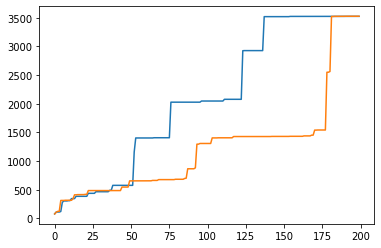

In [28]:
print('maps/trasa2.png')
plt.plot(load_logs('build/logs/DNN_20_0207_230023')[:,4])
plt.plot(load_logs('build/logs/DNN_20_0307_091823')[:,0])
plt.show()

Ilustracja przebiegu na najtrudniejszej mapie `maps/trasa1.png`

![Nie udało się załadować gifa](https://github.com/aprilis/racing-cars/raw/master/video4.gif)

Tak nauczona populacja radzi potrafi też w pewnym stopniu generalizować, poniżej pokazano, jak radzi sobie na mapie, na której nie była uczona:

![Nie udało się załadować gifa](https://github.com/aprilis/racing-cars/raw/master/video5.gif)

Warto też zauważyć, że większa liczba kryteriów optymalizacji w naturalny sposób promuje różnorodność populacji. Pojazdy w dwóch powyższych przykładach zachowują się w istotnie różny sposób - przede wszystkim jadą z różną prędkością. Z drugiej strony, populacja przy uczeniu na tylko jednej mapie została zdominowana przez kopie jednego osobnika, co doprowadziło do tego, że nie była w stanie nauczyć się pokonać kolejnych przeszkód.

Poniższy test pokazuje jeszcze bardziej wpływ liczby kryteriów na zróżnicowanie populacji i korzyści z tego idące. Poniższa mapa zawiera wiele odnóg, dając pojazdom możliwości decycji, którą wybiorą. Wykonano 2 eksperymenty: jeden, w którym uczenie było tylko z wykorzystaniem tej jednej mapy i drugi, w którym wykorzystano oprócz tego 4 inne.

Algorytm uczony tylko na mapie `maps/opcje1.png`
![Nie udało się załadować gifa](https://github.com/aprilis/racing-cars/raw/master/video8.gif)

Algorytm uczony na mapach `trasa0.png, trasa1.png, trasa2.png, trasa3.png, opcje1.png`
![Nie udało się załadować gifa](https://github.com/aprilis/racing-cars/raw/master/video7.gif)

## Inne eksperymenty

### Okrąg
Optymalny punkt jest dokładnie na przeciwko startu. Niektóre pojazdy wybrały strategię, by rozbić się w tym punkcie, inne, by dojechać tam dokładnie, kiedy minie ograniczenie 30 sekund.
![Nie udało się załadować gifa](https://github.com/aprilis/racing-cars/raw/master/video9.gif)

## CMA-ES
Ewolucja z użyciem algorytmu CMA-ES na teście `maps/trasa2.png`

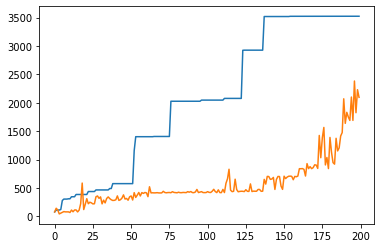

In [35]:
plt.plot(load_logs('build/logs/DNN_20_0207_230023')[:,4])
plt.plot(-load_logs('build/logs/DNN_20_0307_113725'))

## SADE
Ewolucja z użyciem algorytmu SADE (Self-adaptive Differential Evolution) na teście `maps/trasa2.png`

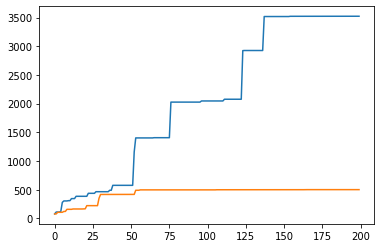

In [36]:
plt.plot(load_logs('build/logs/DNN_20_0207_230023')[:,4])
plt.plot(-load_logs('build/logs/DNN_20_0307_114106'))

## Efektywność implementacji

Projekt został zaimplementowany w języku C++, dzięki czemu działa bardzo efektywnie. Do obliczeń macierzowych wykorzystałem bibliotekę [Armadillo](http://arma.sourceforge.net/), a do wykonania ewolucji bibliotekę [PAGMO 2](https://esa.github.io/pagmo2). Czas działania algorytmu na poszczególnych testach (200 generacji, 80 osobników):

| Mapa | Czas działania | Czas działania/generację |
| :---: | :---: | :---: |
| maps/trasa0.png | 2m 33s | 0,765 s |
| maps/trasa1.png | 2m 8s | 0,64 s|
| maps/trasa2.png | 2m 14s | 0,67s |
| (5 różnych map) | 22m 24 s | 6,27s |

## Instalacja i uruchomienie

Kod źródłowy dostępny jest na stronie [https://github.com/aprilis/racing-cars](https://github.com/aprilis/racing-cars). Instrukcje dotyczące instalacji i uruchomienia znajdują się w pliku [README](https://github.com/aprilis/racing-cars/blob/master/README.md) w tym repozytorium.